In [1]:
import copy

import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [68]:
trials = 144
steps = 2  # number of timepoints per trial

#STATES
# state if the img is cs+ or cs-
state = ['cs+', 'cs-']


#OBSERVATIONS

# morphing level binary. shock only if morph_level=6
morph_level_obs = ['0','1']
# the subject receive the electric shock?
shock_obs = ['shock', 'no shock','null']
# observation to discriminate if the subject is surprised or prepared. A sort of diff between user prediction and shock observation
surprised_obs = ['not_surprised','surprised','null']

#ACTIONS
# the subject predict if should be receive the shock or not
action = ['guess cs+','guess cs-','null']

# Define `num_states` and `num_factors` below
num_states = [len(state)] #[2]
num_factors = len(num_states) #1

#Define `num_obs` and `num_modalities` below
num_obs = [len(morph_level_obs), len(shock_obs), len(surprised_obs)] # [2,2,2]
num_modalities = len(num_obs) #3



In [69]:
len(action)

3

In [70]:
B_ = np.zeros((num_states[0], num_states[0], len(action)))
B_

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [81]:
def matrices(TrialEnv):
    """
    The A, B, C, D, E matrices are built.
    """
    # This is the likelihood mapping that truly describes the relationship between the
    # environment's hidden state and the observations the agent will get

    # A matrix
    # A dimension?
    A = utils.obj_array(num_modalities)
    A_morph = np.zeros((len(morph_level_obs), len(state)))
    A_shock = np.zeros((len(shock_obs), len(state)))
    A_surprise = np.zeros((len(surprised_obs), len(state)))
    #mor_lev_binary/states #cs+ #cs-
    A_morph = np.array([ [0, 1],    #img or
                         [1, 0] ]   #img minac
                          )
    #shock-noshock/states
    A_shock = np.array([ [0.75, 0],
                         [0.25, 1],
                         [0, 0]]
                          )
    #prepared-surprised/states
    A_surprise = np.array([ [0.5, 0.5],
                            [0.5, 0.5],
                            [0, 0]]
                          )
    A[0] = A_morph
    A[1] = A_shock
    A[2] = A_surprise
    # B matrix
    # The transition mapping that truly describes the environment's dynamics

    #B as an identity matrix. no state transitions
    B = utils.obj_array(num_factors)
    B_ = np.zeros((num_states[0], num_states[0], len(action)))

    B_[:,:,0] = np.eye(num_states[0])
    B_[:,:,1] = np.eye(num_states[0])
    B_[:,:,2] = np.eye(num_states[0])


    '''B_[0, :,:] = np.array([ [1, 0],
                           [0, 1] ])
    B_[1, :,:] = np.array([ [1, 0],
                       [0, 1] ])'''

    B[0]=B_
    B_gm = copy.deepcopy(B)  # make a copy of the true transition likelihood to initialize the transition model
    #???
    #A_gm = copy.deepcopy(A_gp)  # make a copy of the true observation likelihood to initialize the observation model
    #???
    #B_gm = copy.deepcopy(B_gp)  # make a copy of the true transition likelihood to initialize the transition model


    # This is the matrix representing the preferences over outcomes
    #prepared-surprised/cs+-
    C = utils.obj_array_zeros(num_obs)          #num modalities
    C[0] = np.array([4.0,-6.0])
    C[1] = np.zeros(3)
    C[2] = np.zeros(3)


    return A, B_gm, C

In [82]:
data

,morphing level,shock
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
139,0,0
140,0,0
141,0,0
142,0,0


In [150]:
class TrialEnv(object):
    def __init__(self,data):
        """
        Constructor of the environment
        :param data: Dataframe with 4 columns: 'trial_number','morphing_level','condition','shock'

        'trial_number': number of trial in the experiment
        'morphing_level': 1 if cs+, 0 otherwise
        'condition': 1 cs+, 0 otherwise
        'shock': 1 if the shock is given at this trial, 0 otherwise

        """
        self.data = data

    def get_observation(self,param,trial_number):
        '''

        :param param: column of the dataframe that you want to read
        :param trial_number:
        :return: value of the specific column in the trial_number row
        '''
        value= str(self.data.iloc[int(trial_number)][param])

        if param == 'shock':
            if value == '1':
                value = 'shock'
            if value == '0':
                value = 'no shock'

        return value

    def step(self, action,current_trial):
        '''
        Take a step in the environment given an action

        :param action:
        :param current_trial:
        :return:
        '''
        surprised_obs = None
        if action == 'null':
            return 'null'
        if action == 'guess cs+':
            shock_obs = self.get_observation(param='shock',trial_number=current_trial)

            if shock_obs == 'shock': # in this case shock and i have predicted cs+ #TODO change this
                print("reward")
                surprised_obs = self.get_surprised_low()

            else: # in this case no shock and i have predicted cs+
                print("penalty")
                surprised_obs = self.get_surprised_high()


        if action == 'guess cs-':
            shock_obs = self.get_observation(param='shock',trial_number=current_trial)

            if shock_obs == 'shock': # in this case shock and prediction cs- #TODO change this
                print("penalty")
                surprised_obs = self.get_surprised_high()

            else: # in this case no shock and prediction cs-
                print("reward")
                surprised_obs = self.get_surprised_low()

        if surprised_obs is None:
            print('ERROR: Action not supported!')

        return surprised_obs


    def get_surprised_high(self):
        return 'surprised'

    def get_surprised_low(self):
        return 'not_surprised'


In [151]:
A,B,C = matrices(TrialEnv)
B[0]

array([[[1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.]]])

In [152]:
def load_data(columns=[], binary_morphing_level=False, shock_as_int = False,subject_number=0,remove_first_trials=None,remove_last_trials=None):
    '''
    Function that read NewLookAtMe files and extract
    :param columns:
    :param binary_morphing_level:
    :param shock_as_int:
    :param subject_number:
    :return:
    '''

    df = pd.read_csv('./data/newLookAtMe/newLookAtMe01.csv')
    df = df.filter(columns)

    if 'morphing level' in columns and binary_morphing_level:
        df['morphing level'] = [int(d==6) for d in df['morphing level']]
    if 'shock' in columns and shock_as_int:
        df['shock'] = df['shock'].astype(int)
    if remove_first_trials is not None:
        df = df[remove_first_trials:]
        df.reset_index(drop=True,inplace=True)
    return df

In [153]:
data= load_data(columns=['morphing level','shock'] ,binary_morphing_level=True, shock_as_int = True,remove_first_trials=16)
data

,morphing level,shock
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
139,0,0
140,0,0
141,0,0
142,0,0


In [154]:
morphing_levels = [0] * 72 + [1] * 72
shocks = [0] * 72 + [1] * 72
fake_data_half = pd.DataFrame({'morphing level': morphing_levels, 'shock': shocks})
fake_data_half

,morphing level,shock
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
139,1,1
140,1,1
141,1,1
142,1,1


In [155]:
def plot_states(states):
    """
    Plot the belief about the context state (left or right) over 64 trials in non-affective agent.
    The plot is given only for the following policies: Left-Left, Right-Right, Cue-Left, Cue-Right.
    """
    fig, ((img11, img12), (img21, img22), (img31, img32), (img41, img42)) = plt.subplots(4, 2, figsize=(16, 8))

    x = np.linspace(0, 64, 64)
    # policy LL - Left state
    y110 = states[4][0][0]  # first index is the policy, second is the timestamp, third is the context state
    y111 = states[4][1][0]
    y112 = states[4][2][0]
    #y113 = states[4][3][0]
    # policy LL - Right state
    y120 = states[4][0][1]
    y121 = states[4][1][1]
    y122 = states[4][2][1]
    #y123 = states[4][3][1]
    # policy RR - Left state
    y210 = states[5][0][0]
    y211 = states[5][1][0]
    y212 = states[5][2][0]
    #y213 = states[5][3][0]
    # policy RR - Right state
    y220 = states[5][0][1]
    y221 = states[5][1][1]
    y222 = states[5][2][1]
    #y223 = states[5][3][1]
    # policy CL - Left state
    y310 = states[7][0][0]
    y311 = states[7][1][0]
    y312 = states[7][2][0]
    #y313 = states[7][3][0]
    # policy CL - Right state
    y320 = states[7][0][1]
    y321 = states[7][1][1]
    y322 = states[7][2][1]
    #y323 = states[7][3][1]
    # policy CR - Left state
    y410 = states[8][0][0]
    y411 = states[8][1][0]
    y412 = states[8][2][0]
    #y413 = states[8][3][0]
    # policy CR - Right state
    y420 = states[8][0][1]
    y421 = states[8][1][1]
    y422 = states[8][2][1]
    #y423 = states[8][3][1]

    # policy Left-Left
    img11.set_title('Left state')
    img11.set_ylabel('LL policy')
    img11.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img11.set_xticks(np.arange(0, 193, 12), [])
    img11.set_yticks(np.arange(0, 1.1, 0.2))
    img11.plot(x, y110, color='limegreen', label='t1')
    img11.plot(x, y111, color='cornflowerblue', label='t2')
    img11.plot(x, y112, color='deeppink', label='t3')
    #img11.plot(x, y113, color='darkorange', label='Center')

    img12.set_title('Right state')
    img12.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img12.set_xticks(np.arange(0, 193, 12), [])
    img12.set_yticks(np.arange(0, 1.1, 0.2))
    img12.plot(x, y120, color='limegreen', label='t1')
    img12.plot(x, y121, color='cornflowerblue', label='t2')
    img12.plot(x, y122, color='deeppink', label='t3')

    # policy Right-Right
    img21.set_ylabel('RR policy')
    img21.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img21.set_xticks(np.arange(0, 193, 12), [])
    img21.set_yticks(np.arange(0, 1.1, 0.2))
    img21.plot(x, y210, color='limegreen', label='t1')
    img21.plot(x, y211, color='cornflowerblue', label='t2')
    img21.plot(x, y212, color='deeppink', label='t3')

    img22.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img22.set_xticks(np.arange(0, 193, 12), [])
    img22.set_yticks(np.arange(0, 1.1, 0.2))
    img22.plot(x, y220, color='limegreen', label='t1')
    img22.plot(x, y221, color='cornflowerblue', label='t2')
    img22.plot(x, y222, color='deeppink', label='t3')

    # policy Cue-Left
    img31.set_ylabel('CL policy')
    img31.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img31.set_xticks(np.arange(0, 193, 12), [])
    img31.set_yticks(np.arange(0, 1.1, 0.2))
    img31.plot(x, y310, color='limegreen', label='t1')
    img31.plot(x, y311, color='cornflowerblue', label='t2')
    img31.plot(x, y312, color='deeppink', label='t3')

    img32.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img32.set_xticks(np.arange(0, 193, 12), [])
    img32.set_yticks(np.arange(0, 1.1, 0.2))
    img32.plot(x, y320, color='limegreen', label='t1')
    img32.plot(x, y321, color='cornflowerblue', label='t2')
    img32.plot(x, y322, color='deeppink', label='t3')

    # policy Cue-Right
    img41.set_ylabel('CR policy')
    img41.set_xlabel('trials')
    img41.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img41.set_xticks(np.arange(0, 193, 12), np.arange(0, 65, 4).tolist())
    img41.set_yticks(np.arange(0, 1.1, 0.2))
    img41.plot(x, y410, color='limegreen', label='t1')
    img41.plot(x, y411, color='cornflowerblue', label='t2')
    img41.plot(x, y412, color='deeppink', label='t3')

    img42.set_xlabel('trials')
    img42.axvline(x=32, color='deepskyblue', label='context reversal', linestyle='dotted')
    img42.set_xticks(np.arange(0, 193, 12), np.arange(0, 65, 4).tolist())
    img42.set_yticks(np.arange(0, 1.1, 0.2))
    img42.plot(x, y420, color='limegreen', label='t1')
    img42.plot(x, y421, color='cornflowerblue', label='t2')
    img42.plot(x, y422, color='deeppink', label='t3')

    plt.show()


In [158]:
# define an agent
my_agent = Agent(A = A, B = B, C = C, inference_horizon=2, inference_algo="MMP", use_BMA=True, policy_sep_prior=False, save_belief_hist=True, sampling_mode="full")
qs0= my_agent.qs
# define an environment
my_env = TrialEnv(data= fake_data_half)
list_qs = []
list_action = []

initial_action = 'first_action'

# iterate over all trials
for trial in range (trials) :
    print("\n-----TRIAL "+str(trial)+ " ------")

    for step in range (steps) : #each trial divided in two steps
        #si puo inserire un my_env.reset()
        agent_stimul_obs = my_env.get_observation(param='morphing level',trial_number=trial)

        if step == 0:
            agent_surpr_obs = 'null'
            agent_shock_obs = 'null'
            action_name='null'

        if step == 1:
            agent_shock_obs = my_env.get_observation(param='shock',trial_number=trial)
            print('observation:',agent_shock_obs)

        obs_ = [morph_level_obs.index(agent_stimul_obs), shock_obs.index(agent_shock_obs), surprised_obs.index(agent_surpr_obs)]
        qs = my_agent.infer_states (observation=obs_) # agent update beliefs about hidden states given observations

        policies = my_agent.infer_policies () # inferring policies and sampling actions from the posterior
        print('step: ',step,'policies: ', policies)

        print('***')
        print(qs[0][0])
        list_qs.append(qs[0][0])

        agent_action = my_agent.sample_action()
        action_name = action[int(agent_action)]
        if step==0:
            agent_surpr_obs = my_env.step(action_name,trial)
            print('observation is cs+: '+agent_stimul_obs)
            #print('distribution states:',state_distr_inferred)
            print('action done: '+action_name)
        list_action.append(action_name)

        print('SURPR OBS',agent_surpr_obs)
    # at the end of each trial, update the prior over hidden states, via the Dirichlet prior `pD`
    #my_agent.update_D(qs)
    # at the end of the trial reset
    if step ==1:
        my_agent.reset(init_qs= qs)



-----TRIAL 0 ------
step:  0 policies:  (array([0.33333333, 0.33333333, 0.33333333]), array([-13.00824492, -13.00824492, -13.00824492]))
***
[array([0.5, 0.5])]
penalty
observation is cs+: 0
action done: guess cs+
SURPR OBS surprised
observation: no shock
step:  1 policies:  (array([0.33333333, 0.33333333, 0.33333333]), array([-4.3945395, -4.3945395, -4.3945395]))
***
[array([1.87469133e-08, 9.99999981e-01])]
SURPR OBS surprised

-----TRIAL 1 ------
step:  0 policies:  (array([0.33333333, 0.33333333, 0.33333333]), array([-4.3945395, -4.3945395, -4.3945395]))
***
[array([3.75436198e-22, 1.00000000e+00])]
penalty
observation is cs+: 0
action done: guess cs+
SURPR OBS surprised
observation: no shock
step:  1 policies:  (array([0.33333333, 0.33333333, 0.33333333]), array([-4.3945395, -4.3945395, -4.3945395]))
***
[array([2.27577399e-12, 1.00000000e+00])]
SURPR OBS surprised

-----TRIAL 2 ------
step:  0 policies:  (array([0.33333333, 0.33333333, 0.33333333]), array([-4.3945395, -4.3945395

In [159]:
step=0
list_csplus=[]
list_csminus=[]
for index, value in enumerate(list_qs):
    step = step+1
    if (index%2)==0:
        list_csplus.append(value[0][0])
        list_csminus.append(value[0][1])
        step=0
    print('trial:',round(index/2),'- step:',step,' ',value[0][0], '  ',value[0][1])

trial: 0 - step: 0   0.5    0.5
trial: 0 - step: 1   1.874691329465789e-08    0.9999999812530868
trial: 1 - step: 0   3.75436197535142e-22    1.0
trial: 2 - step: 1   2.2757739914370554e-12    0.9999999999977243
trial: 2 - step: 0   3.841933200891674e-23    1.0
trial: 2 - step: 1   2.4556414174872026e-14    0.9999999999999754
trial: 3 - step: 0   1.2305865739357432e-23    1.0
trial: 4 - step: 1   2.5977147867372726e-15    0.9999999999999973
trial: 4 - step: 0   7.054855166784992e-24    1.0
trial: 4 - step: 1   8.994559217248234e-16    0.9999999999999991
trial: 5 - step: 0   5.4962563716244786e-24    1.0
trial: 6 - step: 1   5.703359817597229e-16    0.9999999999999993
trial: 6 - step: 0   4.971115317844307e-24    1.0
trial: 6 - step: 1   4.773112629508575e-16    0.9999999999999996
trial: 7 - step: 0   4.787861639249171e-24    1.0
trial: 8 - step: 1   4.469507542909185e-16    0.9999999999999996
trial: 8 - step: 0   4.723272791387098e-24    1.0
trial: 8 - step: 1   4.365080162588425e-16  

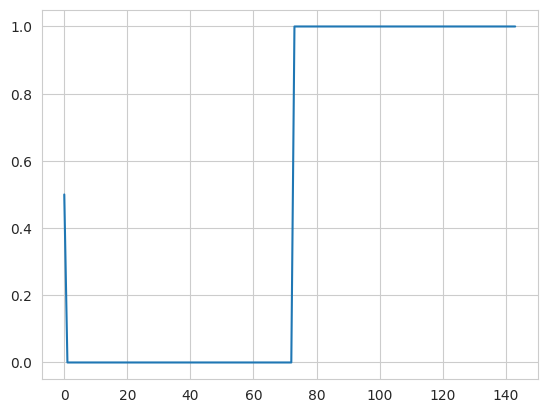

In [160]:
plt.plot(list_csplus)

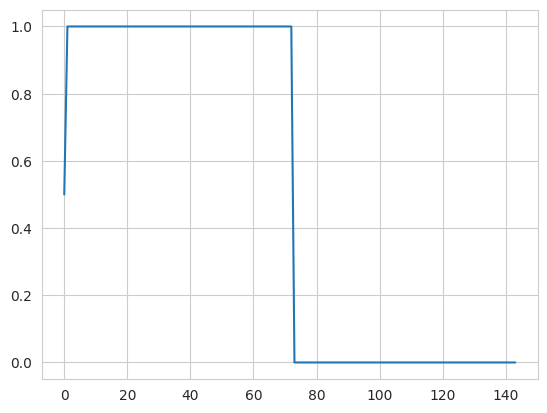

In [161]:
plt.plot(list_csminus)

In [163]:
for index, value in enumerate(list_action):
    step = step+1
    if (index%2)==0:
        step=0
    print('trial:',round(index/2),'- step:',step,' ',value)

trial: 0 - step: 0   guess cs+
trial: 0 - step: 1   guess cs+
trial: 1 - step: 0   guess cs+
trial: 2 - step: 1   guess cs+
trial: 2 - step: 0   guess cs+
trial: 2 - step: 1   guess cs+
trial: 3 - step: 0   guess cs+
trial: 4 - step: 1   guess cs+
trial: 4 - step: 0   guess cs+
trial: 4 - step: 1   guess cs+
trial: 5 - step: 0   guess cs+
trial: 6 - step: 1   guess cs+
trial: 6 - step: 0   guess cs+
trial: 6 - step: 1   guess cs+
trial: 7 - step: 0   guess cs+
trial: 8 - step: 1   guess cs+
trial: 8 - step: 0   guess cs+
trial: 8 - step: 1   guess cs+
trial: 9 - step: 0   guess cs+
trial: 10 - step: 1   guess cs+
trial: 10 - step: 0   guess cs+
trial: 10 - step: 1   guess cs+
trial: 11 - step: 0   guess cs+
trial: 12 - step: 1   guess cs+
trial: 12 - step: 0   guess cs+
trial: 12 - step: 1   guess cs+
trial: 13 - step: 0   guess cs+
trial: 14 - step: 1   guess cs+
trial: 14 - step: 0   guess cs+
trial: 14 - step: 1   guess cs+
trial: 15 - step: 0   guess cs+
trial: 16 - step: 1   guess